In [1]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dropout, Dense, Activation

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime

In [3]:
from tensorflow.python.client import device_lib
device_lib.list_local_devices()

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 15116890355622651208]

In [4]:
df = pd.read_csv('data/medibloc.csv', encoding='cp949')
df.head()

,날짜,시가,고가,저가,종가,거래량,시가총액
0,04-Apr-20,2.93,2.96,2.86,2.91,"156,557,373","7,257,735,356"
1,05-Apr-20,2.92,2.94,2.85,2.88,"111,694,036","7,171,533,960"
2,06-Apr-20,2.88,3.05,2.85,3.05,"305,791,568","7,614,393,498"
3,07-Apr-20,3.05,3.08,2.94,2.97,"293,938,261","7,418,205,862"
4,08-Apr-20,2.97,3.07,2.95,3.02,"157,477,523","7,535,574,853"


In [5]:
# 당일 중간가격 구하기
high_prices = df['고가'].values
low_prices = df['저가'].values
mid_prices = (high_prices+low_prices)/2 

In [6]:
len(mid_prices)

364

In [7]:
# 최근 7일을 기준으로 다음날 가격을 예측
seq_len = 7
squence_length = seq_len + 1
result = []
for index in range(len(mid_prices) - squence_length):
    result.append(mid_prices[index: index + squence_length])

In [8]:
result[0]

array([2.91 , 2.895, 2.95 , 3.01 , 3.01 , 3.035, 2.92 , 2.835])

In [9]:
# 정규화
normalized_data = []
for window in result:
    normalized_window = [((float(p)/float(window[0])) - 1)for p in window]
    normalized_data.append(normalized_window)
    
result = np.array(normalized_data)

In [10]:
result.shape

(356, 8)

In [11]:
#data split
row = int(round(result.shape[0]*0.9))
train = result[:row,:]
np.random.shuffle(train)

x_train = train[:,:-1]
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1],1))
y_train = train[:,-1]

x_test = result[row:,:-1]
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1],1))
y_test = result[row:,-1]
x_train.shape, x_test.shape, y_train.shape, y_test.shape

((320, 7, 1), (36, 7, 1), (320,), (36,))

In [50]:
# LSTM  모델구현
model = Sequential()
model.add(LSTM(255,return_sequences=True, input_shape=(7,1)))
model.add(LSTM(64,return_sequences=False))
model.add(Dense(1,activation='relu'))
model.compile(optimizer='adam', loss='mse', metrics=['mae'])
model.summary()

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_18 (LSTM)               (None, 7, 255)            262140    
_________________________________________________________________
lstm_19 (LSTM)               (None, 64)                81920     
_________________________________________________________________
dense_9 (Dense)              (None, 1)                 65        
Total params: 344,125
Trainable params: 344,125
Non-trainable params: 0
_________________________________________________________________


In [13]:
# Early Stopping
es = tf.keras.callbacks.EarlyStopping(monitor='val_loss',patience=10, verbose=1)

In [51]:
history = model.fit(x_train, y_train,
          validation_data=(x_test, y_test),
          batch_size=20, epochs=500, callbacks=es)

Epoch 1/500
16/16 [==============================] - 4s 112ms/step - loss: 0.0621 - mae: 0.1128 - val_loss: 0.2801 - val_mae: 0.3831
Epoch 2/500
16/16 [==============================] - 0s 9ms/step - loss: 0.0390 - mae: 0.0805 - val_loss: 0.2538 - val_mae: 0.3605
Epoch 3/500
16/16 [==============================] - 0s 9ms/step - loss: 0.0193 - mae: 0.0725 - val_loss: 0.2124 - val_mae: 0.3192
Epoch 4/500
16/16 [==============================] - 0s 8ms/step - loss: 0.0294 - mae: 0.0806 - val_loss: 0.2267 - val_mae: 0.3363
Epoch 5/500
16/16 [==============================] - 0s 9ms/step - loss: 0.0258 - mae: 0.0722 - val_loss: 0.1948 - val_mae: 0.3029
Epoch 6/500
16/16 [==============================] - 0s 9ms/step - loss: 0.0097 - mae: 0.0574 - val_loss: 0.1198 - val_mae: 0.2244
Epoch 7/500
16/16 [==============================] - 0s 10ms/step - loss: 0.0162 - mae: 0.0689 - val_loss: 0.1526 - val_mae: 0.2641
Epoch 8/500
16/16 [==============================] - 0s 9ms/step - loss: 0.0223 

Epoch 63/500
16/16 [==============================] - 0s 9ms/step - loss: 0.0180 - mae: 0.0652 - val_loss: 0.0615 - val_mae: 0.1764
Epoch 64/500
16/16 [==============================] - 0s 10ms/step - loss: 0.0108 - mae: 0.0592 - val_loss: 0.0590 - val_mae: 0.1719
Epoch 65/500
16/16 [==============================] - 0s 10ms/step - loss: 0.0187 - mae: 0.0627 - val_loss: 0.0671 - val_mae: 0.1872
Epoch 66/500
16/16 [==============================] - 0s 9ms/step - loss: 0.0143 - mae: 0.0636 - val_loss: 0.0586 - val_mae: 0.1707
Epoch 00066: early stopping


In [52]:
model.evaluate(x_test, y_test)

2/2 [==============================] - 0s 4ms/step - loss: 0.0586 - mae: 0.1707


[0.058640897274017334, 0.1707201898097992]

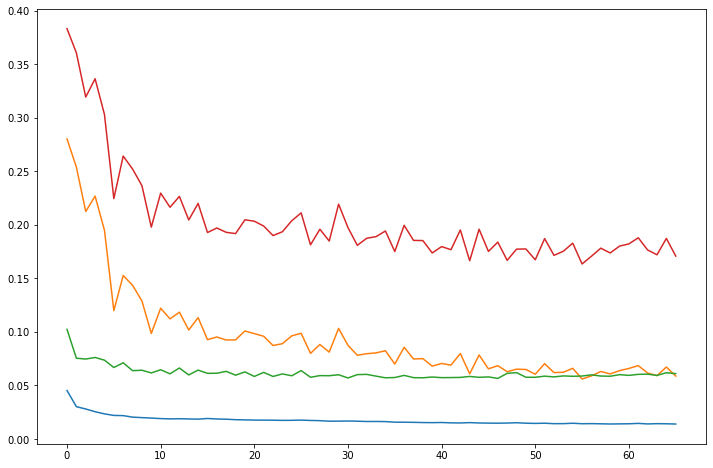

In [54]:
plt.figure(figsize=(12,8))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.plot(history.history['mae'])
plt.plot(history.history['val_mae'])
plt.show()

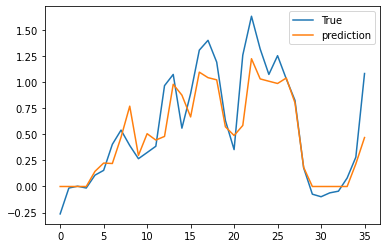

In [55]:
pred = model.predict(x_test)

fig = plt.figure(facecolor='white')
ax = fig.add_subplot(1,1,1)
ax.plot(y_test,label='True')
ax.plot(pred, label='prediction')
ax.legend()
plt.show()